In [ ]:
# installation
! pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3 MB 5.6 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=636fa5aca1020c4af05730face51c3af975e7d473b1f1cf9bf2ae8e9442e5b04
  Stored in directory: /tmp/pip-ephem-wheel-cache-ra5mg2xt/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf

msft = yf.Ticker("MSFT")

# get stock info
msft.info

# get historical market data
hist = msft.history(period="max")
print(hist)

                  Open        High  ...  Dividends  Stock Splits
Date                                ...                         
1986-03-13    0.056001    0.064236  ...        0.0           0.0
1986-03-14    0.061491    0.064785  ...        0.0           0.0
1986-03-17    0.063687    0.065334  ...        0.0           0.0
1986-03-18    0.064785    0.065334  ...        0.0           0.0
1986-03-19    0.063138    0.063687  ...        0.0           0.0
...                ...         ...  ...        ...           ...
2021-10-21  307.170013  311.019989  ...        0.0           0.0
2021-10-22  310.399994  311.089996  ...        0.0           0.0
2021-10-25  309.359985  309.399994  ...        0.0           0.0
2021-10-26  311.000000  312.399994  ...        0.0           0.0
2021-10-27  316.000000  326.097290  ...        0.0           0.0

[8981 rows x 7 columns]


In [ ]:
type(hist)

pandas.core.frame.DataFrame

In [ ]:
hist.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [ ]:
# we will only use closing price as our target signal, while other prices as additional features if needed
# https://analyzingalpha.com/open-high-low-close-stocks

In [ ]:
# download ticker data from nasdaq, manually extracted 
! wget https://gitlab.com/brainekt_ai/us-stock-ticker/-/raw/main/nasdaq_screener_1635374155108.csv

--2021-10-27 23:21:39--  https://gitlab.com/brainekt_ai/us-stock-ticker/-/raw/main/nasdaq_screener_1635374155108.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 610612 (596K) [text/plain]
Saving to: ‘nasdaq_screener_1635374155108.csv’

nasdaq_screener_163 100%[===================>] 596.30K  --.-KB/s    in 0.08s   

2021-10-27 23:21:39 (7.52 MB/s) - ‘nasdaq_screener_1635374155108.csv’ saved [610612/610612]



In [ ]:
! ls

nasdaq_screener_1635374155108.csv  sample_data


In [ ]:
import pandas as pd

tickers = pd.read_csv("nasdaq_screener_1635374155108.csv")

In [ ]:
tickers.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AACG,ATA Creativity Global American Depositary Shares,$2.28,-0.06,-2.564%,7.153938e+07,China,NaN,75873,Miscellaneous,Service to the Health Industry
1,AACIU,Armada Acquisition Corp. I Unit,$9.95,0.00,0.00%,0.000000e+00,United States,2021.0,3,NaN,NaN
2,AADI,Aadi Bioscience Inc. Common Stock,$27.03,0.12,0.446%,5.640983e+08,United States,NaN,33626,Health Care,Biotechnology: Pharmaceutical Preparations
3,AAL,American Airlines Group Inc. Common Stock,$19.03,-0.36,-1.857%,1.232220e+10,United States,NaN,22076823,Transportation,Air Freight/Delivery Services
4,AAME,Atlantic American Corporation Common Stock,$3.98,-0.10,-2.451%,8.123484e+07,United States,NaN,14868,Finance,Life Insurance


In [ ]:
tickers_ls = list(tickers["Symbol"])

In [ ]:
tickers_ls[:20] # list of all tickers, only showing top 20

['AACG',
 'AACIU',
 'AADI',
 'AAL',
 'AAME',
 'AAOI',
 'AAON',
 'AAPL',
 'AATC',
 'AAWW',
 'ABCB',
 'ABCL',
 'ABCM',
 'ABEO',
 'ABGI',
 'ABIO',
 'ABMD',
 'ABNB',
 'ABOS',
 'ABSI']

company: RILYP


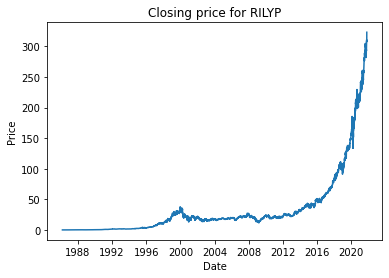

In [ ]:
# choose a random company, plot it's data
import random
import matplotlib.pyplot as plt

comp = random.choice(tickers_ls)
print(f"company: {comp}")

# get data
comp_tick = yf.Ticker("MSFT")

# get historical market data
hist = comp_tick.history(period="max")
plt.plot(hist["Close"])
plt.title(f"Closing price for {comp}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [ ]:
# utils code
# assist

import os
import time

import tqdm
from tqdm import tqdm_notebook

## Data Processing
import pandas as pd
import numpy as np
import matplotlib as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 


#### DATA CREATION FUNCTIONS ####
def create_data(file_list):
    """
    Utility function to create a dataset from a filelist.
    """
    counter = 1
    df_list = pd.DataFrame()
    for file in file_list:
        if (os.stat(file).st_size != 0):
            df = pd.read_csv(file, sep = ",")
            df['symbol'] = file
            df_list = df_list.append(df)
            print (counter, " out of ", len(file_list))
            counter += 1
    return pd.DataFrame(df_list)


def fetch_data():
    """
    Get the files from the data folder. 
    """
    main_dir = os.getcwd()
    # STOCKS
    os.chdir(main_dir)
    os.chdir("./data/Stocks")
    stock_list = os.listdir()
    stocks = create_data(stock_list)
    #ETFs
    os.chdir(main_dir)
    os.chdir("./data/ETFs")
    etf_list = os.listdir()
    etf = create_data(etf_list)

    return stocks, etf


#### DATA PROCESSING FUNCTIONS ####
def scale_df(data, model_name):
    """
    This class takes in a pandas dataframe and generates 
    the normalized version of it
    """
    # scales the data
    scaler = MinMaxScaler()
    df = scaler.fit_transform(data)
    
    return df, scaler


def generate_ta(data):
    """
    Runs ta on a dataset and saves to csv.
    """
    # converts data into ta dataframe
    df = add_all_ta_features(data, "Open", "High", "Low", "Close", "Volume", fillna=True)
    df.to_csv("../data/df_ta.csv")
    

def build_window(df, look_back, n_features):
    """
    Builds sliding windows to shift the batch by 1 step at a time
    """
    x_train = [] # This list contain the sequences to predict when training
    y_train = [] # This list contain the next value of the sequences when training

    for i in range(look_back, df.shape[0]):
        x_train.append(df[i-look_back:i,0:n_features].tolist()) # ,0 used in order to return the values only
        y_train.append(df[i,0].tolist()) # tolist() converts np array to simple array
   
    # Converting arrays from lists to np arrays. 
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Rounding numbers to speed up training.
    x_train = np.round(x_train, 5)
    y_train = np.round(y_train, 5)

    return x_train, y_train


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by the batch size
    """

    no_of_rows_drop = mat.shape[0] % batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

#### FINAL PIPELINE FUNCTION ####
def preproc_pipeline(data, name):
    """
    The preprocessing pipeline takes in a csv of processed data and creates
    the training, validation, and test sets
    """
    # Scale values
    data, scaler = scale_df(data, name)
    # Split
    train_set, testval_set = train_test_split(data, train_size=0.75, test_size=0.25, shuffle=False)
    validation_set, test_set = train_test_split(testval_set, train_size=0.75, test_size=0.25, shuffle=False)
    
    return train_set, validation_set, test_set, scaler


def model_preproc_pipeline(data, look_back, batch_size, n_features):
    """
    preprocesses data for LSTM input
    """
    x_train, y_train = build_window(data, look_back, n_features)

    x_train = trim_dataset(x_train, batch_size)
    y_train = trim_dataset(y_train, batch_size)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features))
    return x_train, y_train
    

def generate_dataset():
        stocks, etf = create_data(".")
        data = pd.concat([stocks, etf])
        generate_ta(data)
        # we have to read file
        data = pd.read_csv("./df_ta.csv")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import CSVLogger

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


def setup_model(n_features, batch_size, look_back):
    """
    Returns a keras LSTM model. Our architecture will be kept 
    in this method.
    """
    model = Sequential()

    model.add(LSTM(units = 64, return_sequences = True, input_shape = (look_back, n_features)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 512, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 64))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model


def train_model(model, x_train, y_train, epochs, batch_size, lr):
    """
    Takes a training dataset and a model and returns a trained model 
    after ts timesteps.
    """
    model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size)

    return model

In [ ]:
# train data
# we only use closing price
data = hist.iloc[:,1:2]
train, valid, test, scalar = preproc_pipeline(data, False)

In [ ]:
# Defining hyper parameters
TIME_STEPS = 100
BATCH_SIZE = 128
N_FEATURES = 1
lr = 0.0001 # learning rate
EPOCHS = 5

In [ ]:
# Create windows, trim windows, and reshape for LSTM input
x_train, y_train = model_preproc_pipeline(train, TIME_STEPS, BATCH_SIZE, N_FEATURES)

In [ ]:
regressor = setup_model(N_FEATURES, BATCH_SIZE, TIME_STEPS)

In [ ]:
# Training the model
regressor = train_model(regressor, x_train, y_train, EPOCHS, BATCH_SIZE, lr)

Epoch 1/5
51/51 [==============================] - 279s 5s/step - loss: 2.7578e-04
Epoch 2/5
51/51 [==============================] - 273s 5s/step - loss: 3.5415e-05
Epoch 3/5
51/51 [==============================] - 270s 5s/step - loss: 3.1106e-05
Epoch 4/5
51/51 [==============================] - 270s 5s/step - loss: 3.2033e-05
Epoch 5/5
51/51 [==============================] - 270s 5s/step - loss: 3.2619e-05


In [ ]:
regressor.evaluate(x_train, y_train)

204/204 [==============================] - 19s 81ms/step - loss: 1.8389e-05


1.838946991483681e-05

In [ ]:
# Preparing test and validation sets
df_test = trim_dataset(test, BATCH_SIZE)
df_val, df_testing = np.split(df_test, 2)

scale = MinMaxScaler()
scaled_df_val = scale.fit_transform(df_val)

In [ ]:
# Reshaping x_val for the LSTM
x_val, y_val = build_window(scaled_df_val, TIME_STEPS, N_FEATURES)

x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))

In [ ]:
# Predicting data using validation data
predicted_stock_price = regressor.predict(x_val)

# Converting back from normalized data
predicted_stock_price = scale.inverse_transform(predicted_stock_price)

<function matplotlib.pyplot.show>

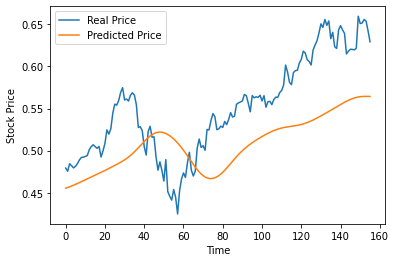

In [ ]:
# Plotting results for seen data
plt.figure()
plt.plot(df_val[TIME_STEPS:])
plt.plot(predicted_stock_price)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(['Real Price', 'Predicted Price'])
plt.show

In [ ]:
# Evaluating model for seen data
from sklearn.metrics import mean_squared_error
EPS = 0.15
mse = mean_squared_error(df_val[TIME_STEPS:], predicted_stock_price)
mse / (df_val[TIME_STEPS:]).mean()

0.006335213322278253

In [ ]:
# Prediction model 1 based on George V Jose
def predict(data, num_prediction):
    # Scaling data
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)

    # Looking at last TIME_STEPS value
    prediction_list = scaled[-TIME_STEPS:]
    
    for _ in range(num_prediction):
        # Looking at last TIME_STEPS value (1 of our batch)
        x = prediction_list[-TIME_STEPS:]
        x = np.array(x)
        
        # 1 batch with TIME_STEPS and 1 feature
        x = x.reshape((1, TIME_STEPS, 1))
        
        # prediction
        print("predicting batch ", x)
        output = model.predict(x)[0][0]
        
        # Appends prediction results back into 
        prediction_list = np.append(prediction_list, output)
        
    prediction_list = prediction_list[TIME_STEPS - 1:]
    
    # Reverse the scaling
    prediction_list = prediction_list.reshape(num_prediction+1, 1)
    prediction_list = scaler.inverse_transform(prediction_list)
    
    return prediction_list

# Prediction model 2 based on Ravindra Compella
def moving_test_window_preds(data, num_predictions, TIME_STEPS, model):
    prediction_list = []
    
    # Scaling data
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    
    moving_test_window = data[-TIME_STEPS:]
    moving_test_window = np.array(moving_test_window)
    
    # Scaling data
    # scaler = MinMaxScaler()
    # moving_test_window = scaler.fit_transform(moving_test_window)
    
    # Reshaping data
    moving_test_window = moving_test_window.reshape((1, TIME_STEPS, 1))
    
    for i in range(num_predictions):
        print("predicting batch ", moving_test_window)
        preds_one_step = model.predict(moving_test_window)
        prediction_list.append(preds_one_step[0,0])
        preds_one_step = preds_one_step.reshape(1,1,1)
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1)
        
    prediction_list = np.array(prediction_list)
    prediction_list = prediction_list.reshape(num_predictions, 1)
    prediction_list = scaler.inverse_transform(prediction_list)
    
    return prediction_list

In [ ]:
# Making predictions with unseen data using a moving window
# Making predictions using the last TIME_STEPS df_val value to predict first 500 values of df_testing
unseen_predictions = moving_test_window_preds(df_val, 500, TIME_STEPS, regressor)

Streaming output truncated to the last 5000 lines.
predicting batch  [[[0.20175973]
  [0.20160186]
  [0.20144491]
  [0.20128889]
  [0.2011338 ]
  [0.20097965]
  [0.20082636]
  [0.200674  ]
  [0.20052253]
  [0.20037192]
  [0.20022222]
  [0.20007336]
  [0.19992539]
  [0.1997783 ]
  [0.19963205]
  [0.19948664]
  [0.1993421 ]
  [0.19919837]
  [0.19905549]
  [0.19891338]
  [0.19877213]
  [0.19863169]
  [0.19849207]
  [0.19835322]
  [0.19821519]
  [0.19807792]
  [0.19794148]
  [0.19780581]
  [0.19767085]
  [0.19753674]
  [0.19740334]
  [0.19727069]
  [0.19713885]
  [0.19700769]
  [0.19687733]
  [0.19674768]
  [0.19661874]
  [0.19649054]
  [0.19636306]
  [0.19623631]
  [0.19611028]
  [0.19598491]
  [0.19586025]
  [0.19573632]
  [0.19561306]
  [0.19549049]
  [0.19536859]
  [0.19524738]
  [0.19512685]
  [0.19500697]
  [0.19488777]
  [0.19476919]
  [0.19465132]
  [0.19453408]
  [0.19441745]
  [0.1943015 ]
  [0.1941862 ]
  [0.1940715 ]
  [0.19395745]
  [0.19384401]
  [0.19373119]
  [0.193619  ]
 

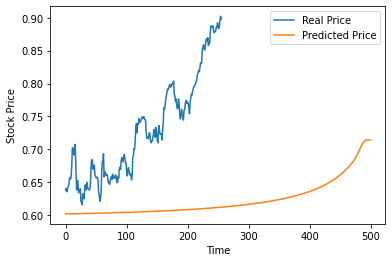

In [ ]:
# Plotting results for unseen data
plt.figure()
plt.plot(df_testing[:500])
plt.plot(unseen_predictions[::-1] + EPS)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(['Real Price', 'Predicted Price'])
plt.show()

In [ ]:
# Evaluating model for unseen data
mse = mean_squared_error(df_testing, unseen_predictions[:256])
mse / (df_testing[:256]).mean()

0.09311470033134978